In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import h5py

import matplotlib.pyplot as plt


import sys, os
sys.path.append("where your code is")

import fit_RF_2D
import RFmap_utils as RFmap
import ReceptiveFieldAnalysis
# clone 

In [2]:
cmaps = {'probeA':'Greys', 
         'probeB':'Blues', 
         'probeC':'Purples', 
         'probeD':'Greens',
         'probeE':'Reds', 
         'probeF':'Oranges'}

cmaps_color = {'probeA':'k', 
         'probeB':'b', 
         'probeC':'purple', 
         'probeD':'green',
         'probeE':'r', 
         'probeF':'orange'}

cmaps = {'probeA':'Reds',
             'probeB':'copper_r',
             'probeC': 'Wistia',
             'probeD': 'Greens',
             'probeE': 'Purples',
             'probeF': 'Blues'}

cmaps_color = {'probeA':'r',
             'probeB':'brown',
             'probeC': '#E3CF57',
             'probeD': 'green',
             'probeE': 'purple',
             'probeF': 'blue'}

#cmaps = {'probeA':'Reds',
#         'probeB':'Browns',
#         'probeC': 'Yellows',
#         'probeD': 'Greens',
#         'probeE': 'Purples',
#         'probeF': 'Blues'}

# run all aggregated RF maps during production

mouse392810
(0.25, 0.0)
probeA
(133, 3645, 300)
0.2
0.3
0.4
0.5
0.6
(2.9565449124020264, 4.414585985891275, 1.0543354562652871)
(0.25, 0.0)
probeB
(111, 3645, 300)
0.2
0.3
0.4
0.5
0.6
0.7
(5.525150617101827, 6.011230402038546, 1.028776518446711)
(0.25, 0.0)
probeC
(136, 3645, 300)
0.2
0.3
0.4
0.5
(4.124142001547852, 3.3482958834496053, 0.9830485879849472)
(0.25, 0.0)
probeD
(105, 3645, 300)
0.2
0.3
0.4
0.5
0.6
(5.089763904822725, 2.4034656156430207, 0.9937147962286998)
(0.25, 0.0)
probeE
(87, 3645, 300)
0.2
0.3
0.4
0.5
(4.076336219017851, 1.498899823647525, 1.5175814463513777)
(0.25, 0.0)
probeF
(89, 3645, 300)
0.2
0.3
0.4
0.5
0.6
0.7
(0.9041474408895498, 6.387743058315725, 1.6025487423132798)
probeA  2.9565449124020264 4.414585985891275
probeB  5.525150617101827 6.011230402038546
probeC  4.124142001547852 3.3482958834496053
probeD  5.089763904822725 2.4034656156430207
probeE  4.076336219017851 1.498899823647525
probeF  0.9041474408895498 6.387743058315725
mouse394208
(0.25, 0.0)
probe

KeyboardInterrupt: 

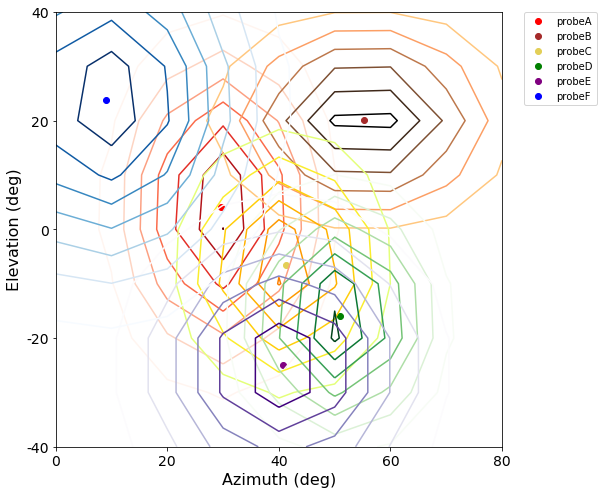

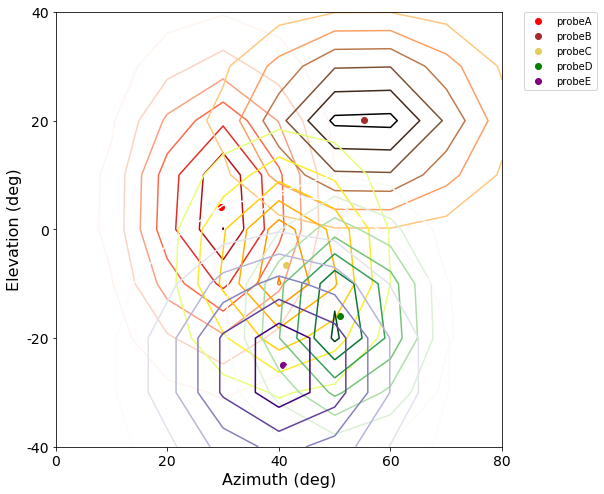

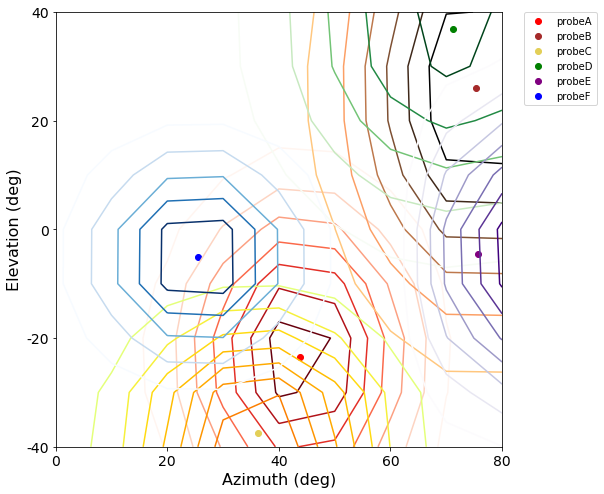

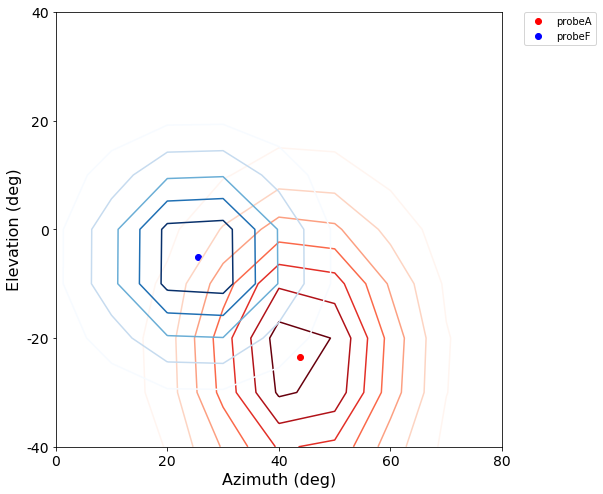

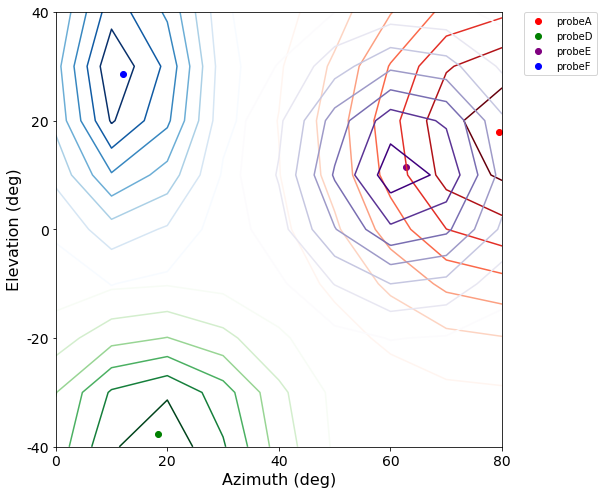

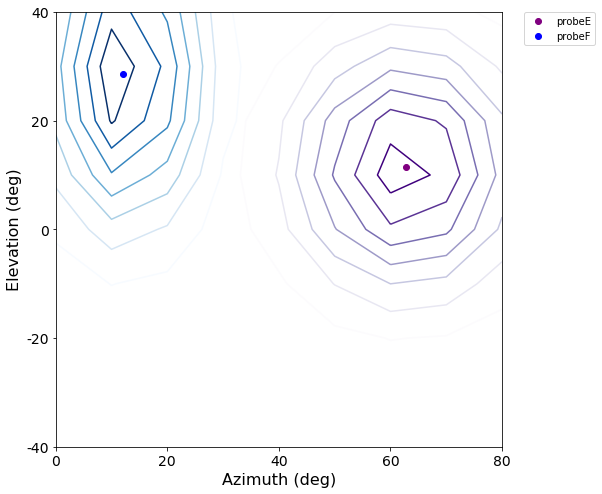

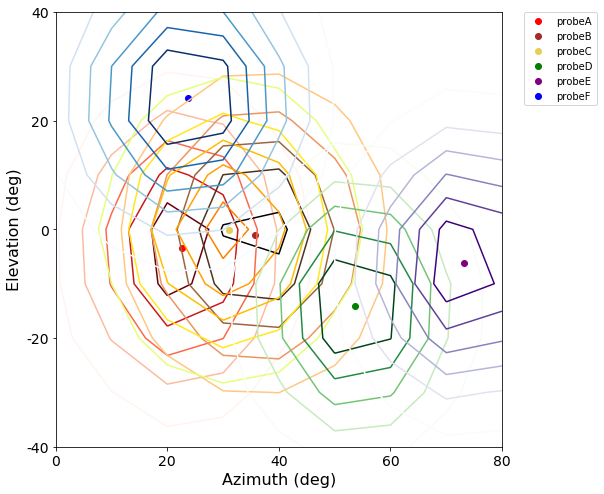

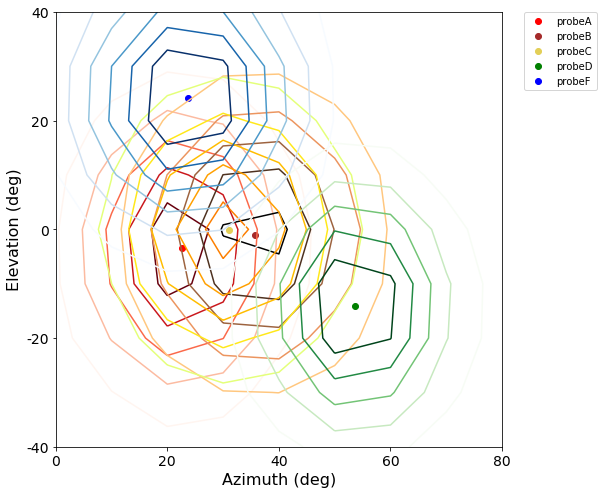

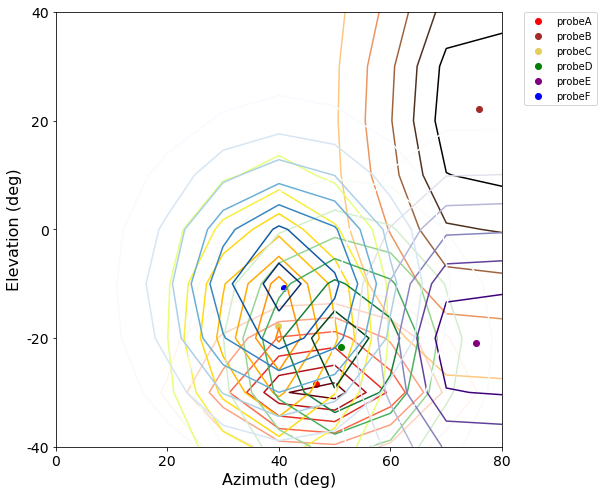

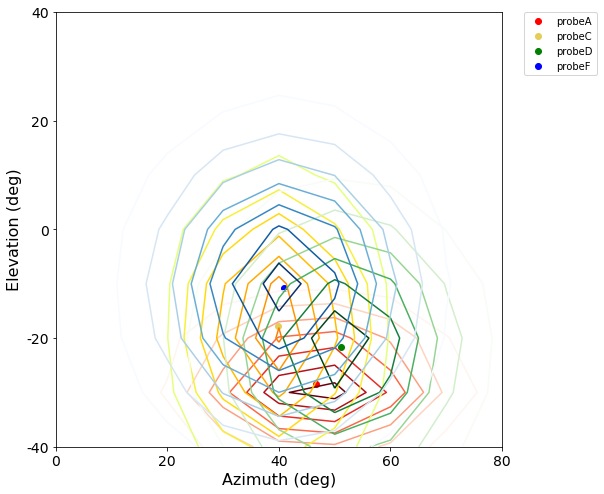

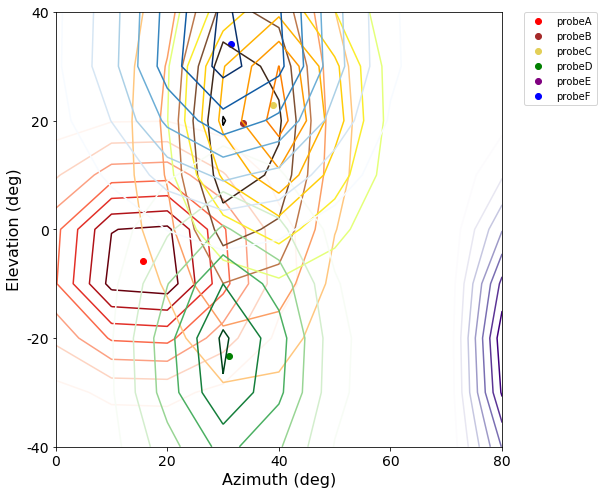

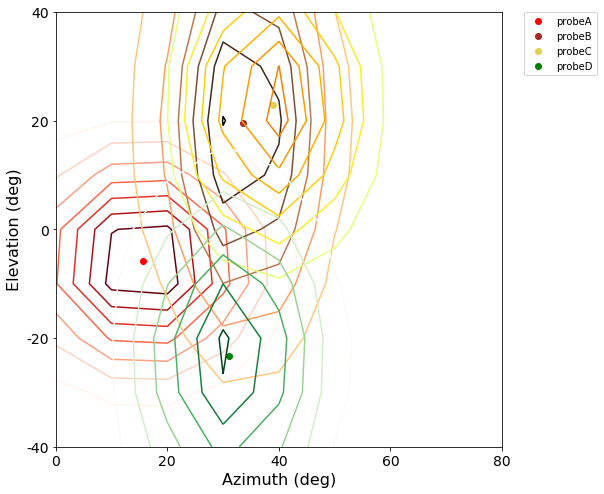

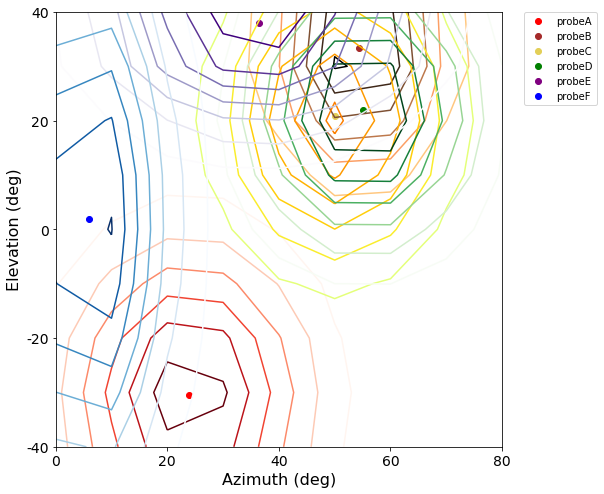

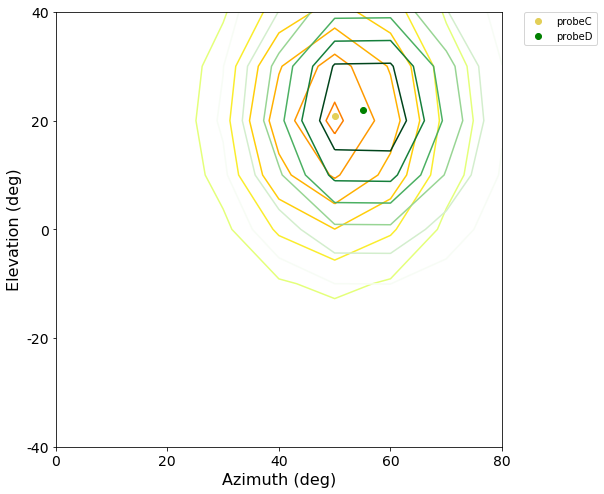

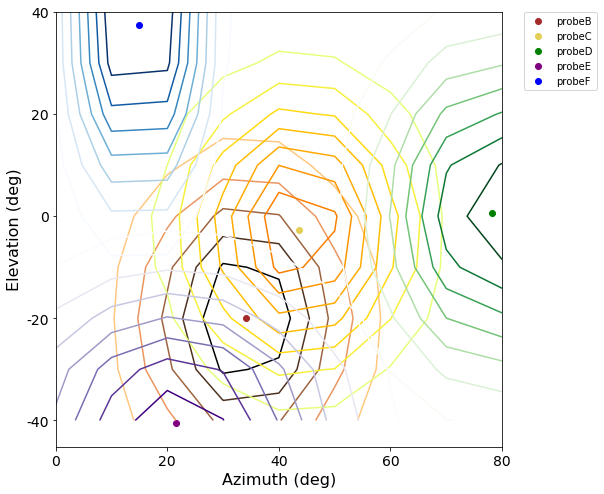

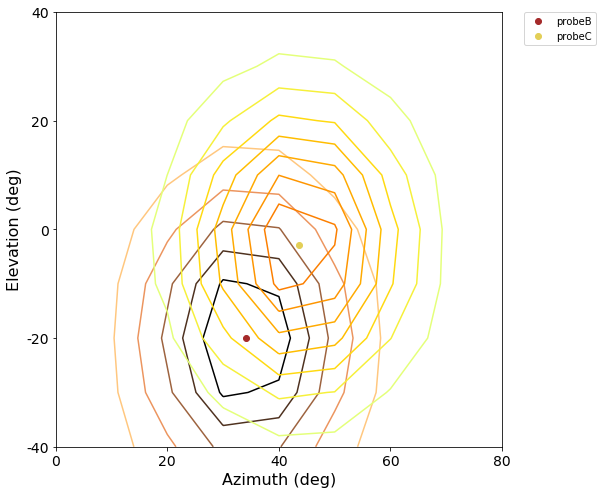

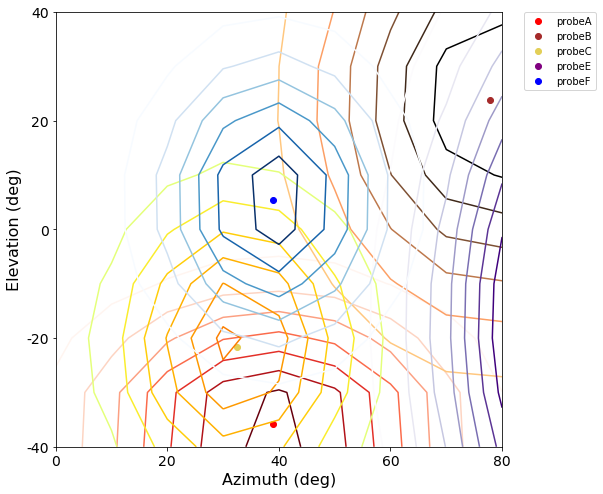

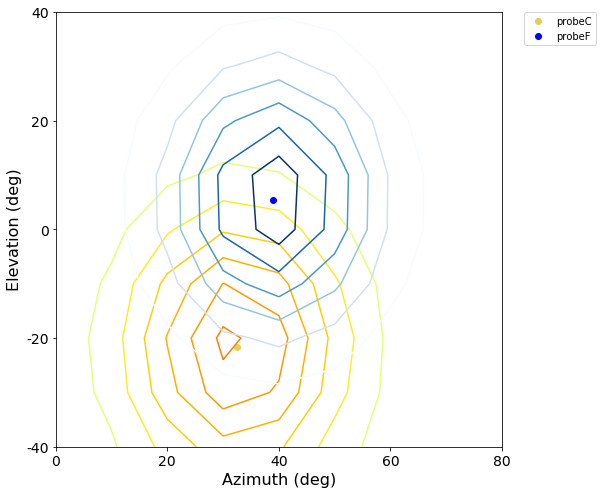

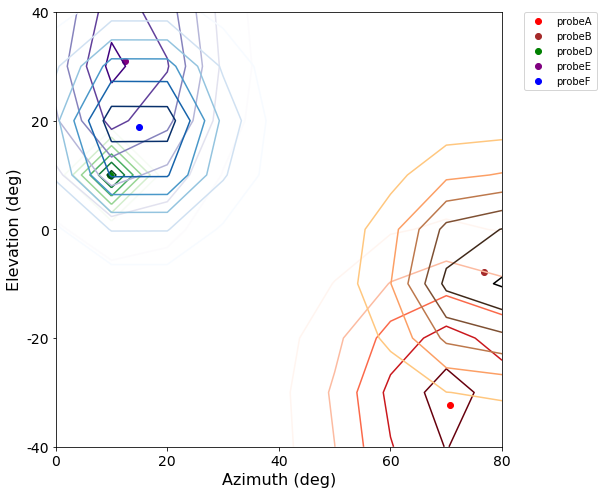

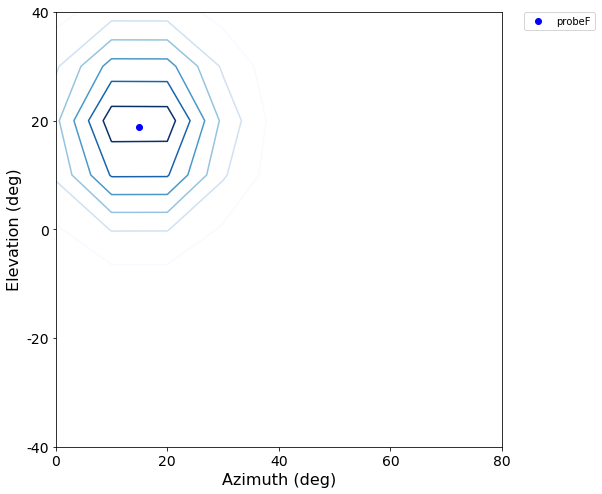

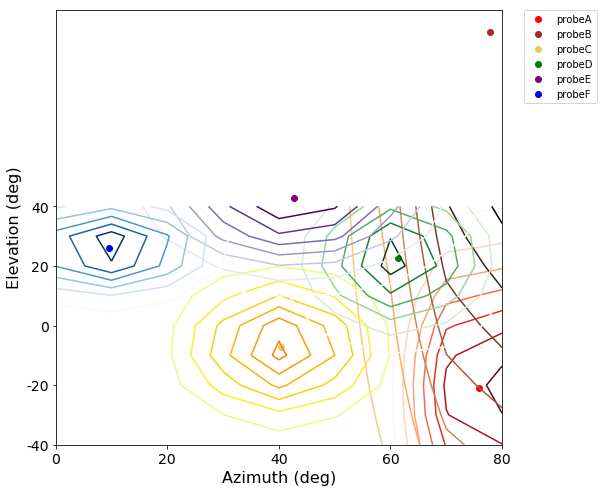

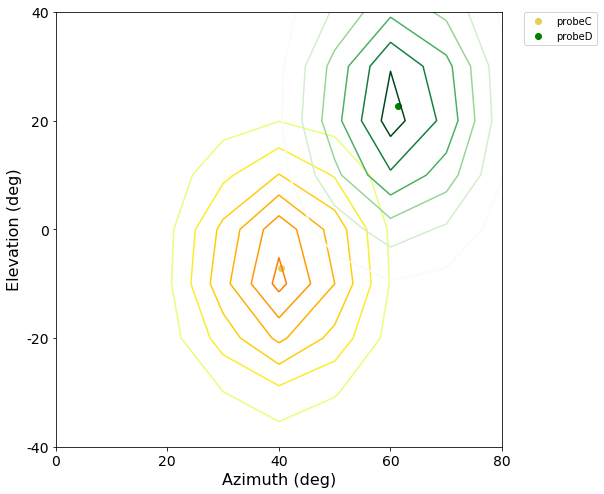

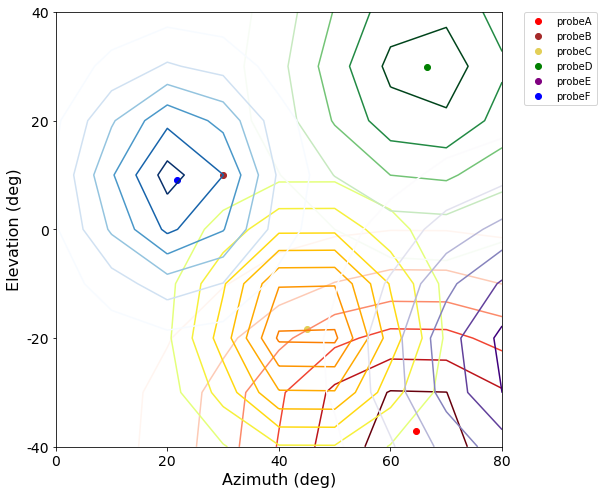

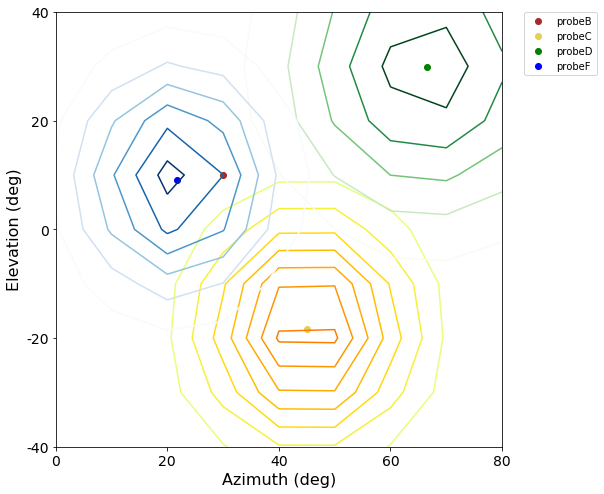

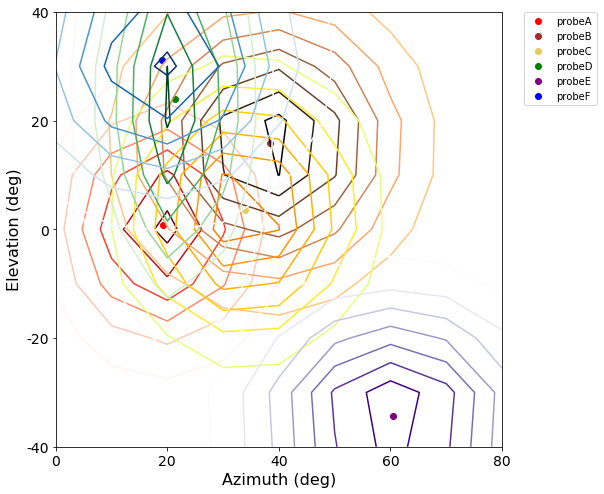

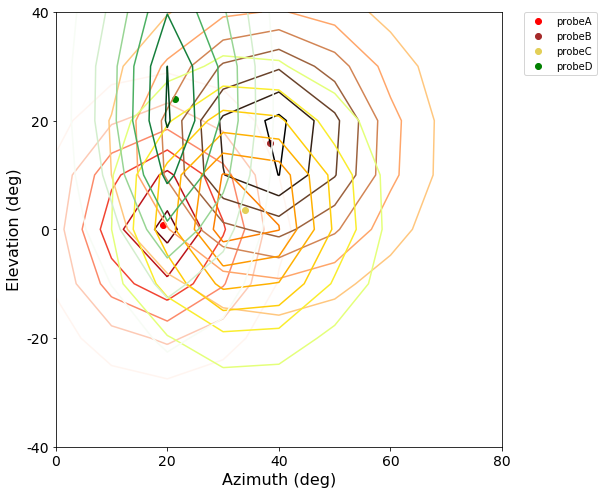

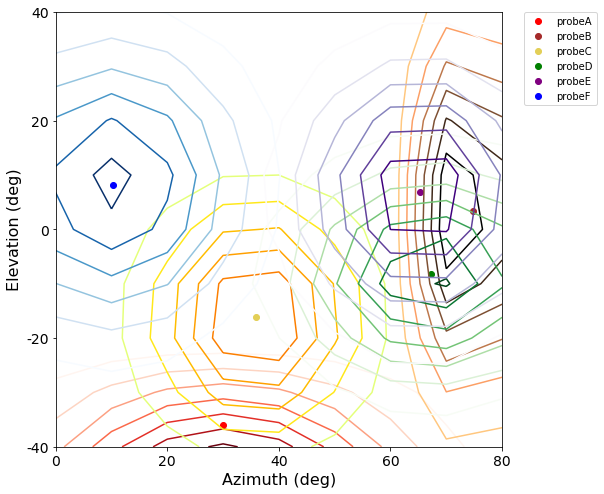

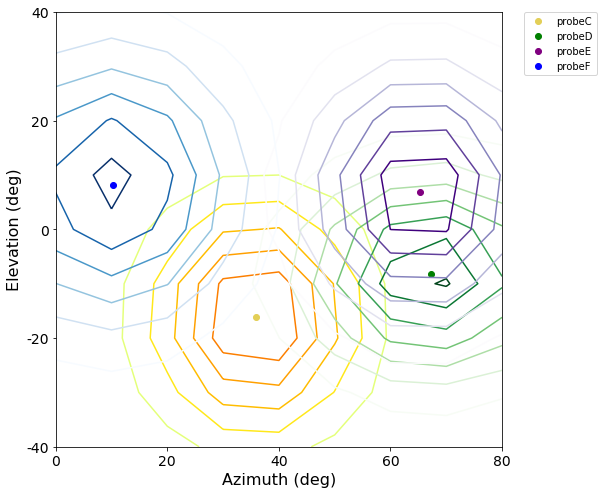

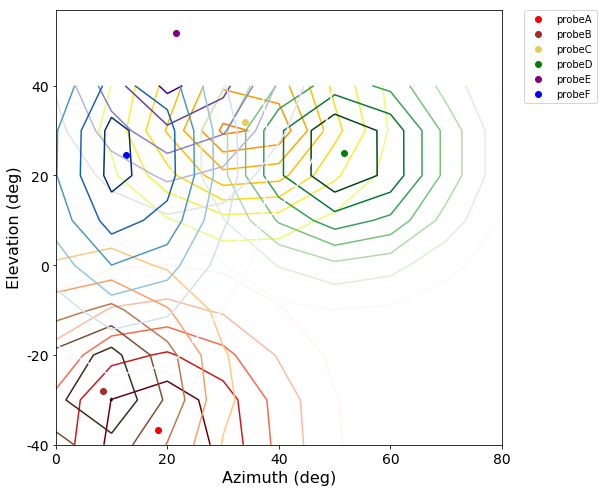

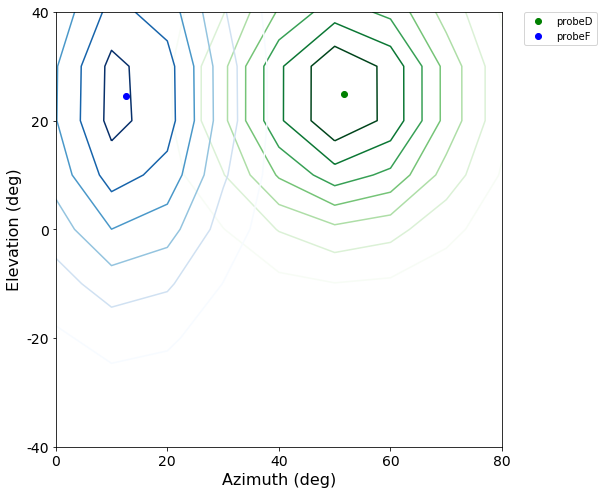

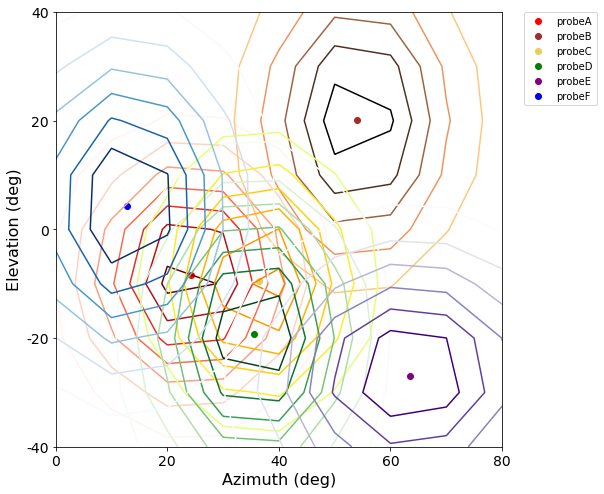

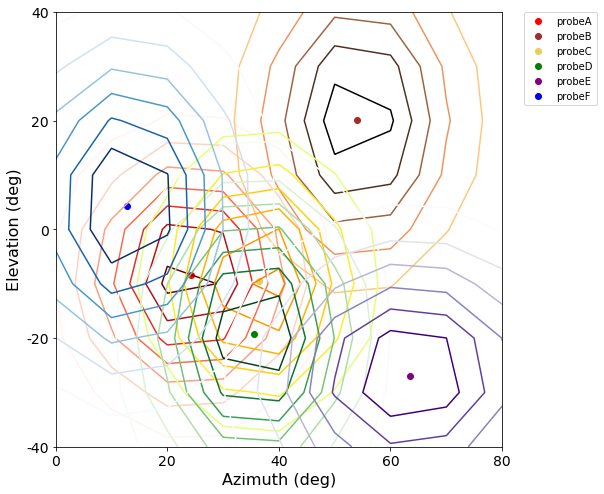

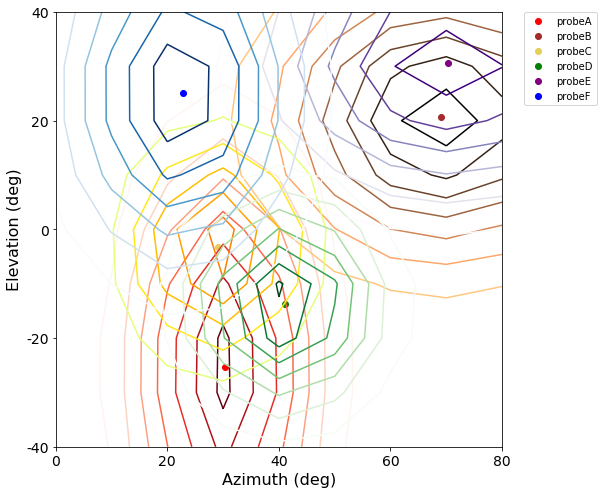

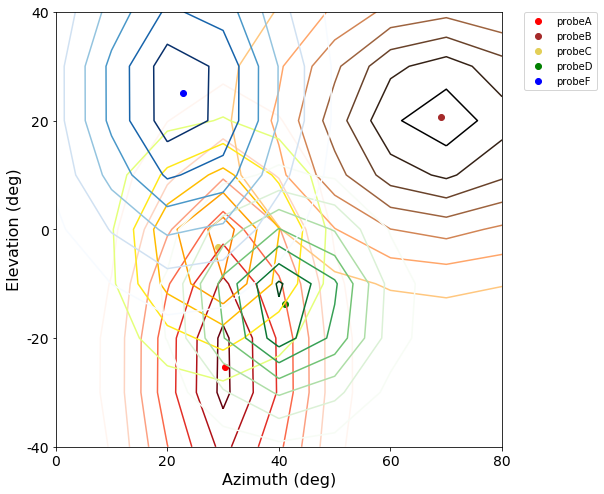

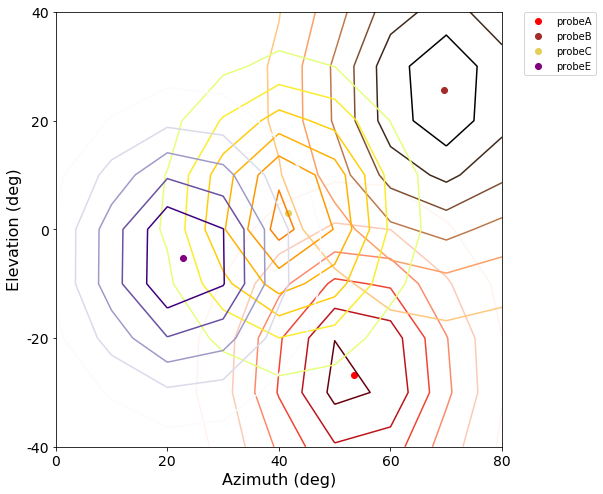

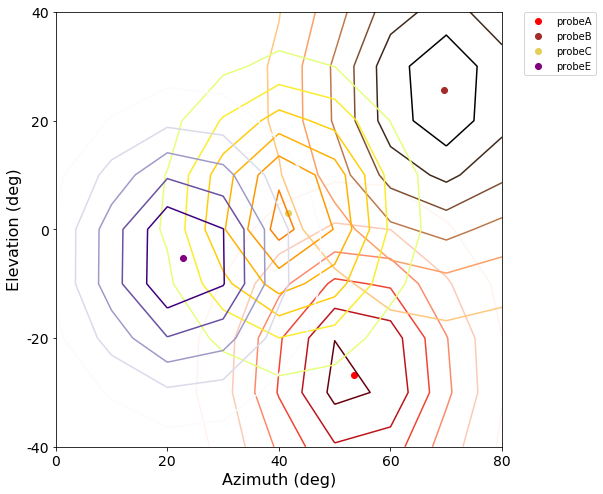

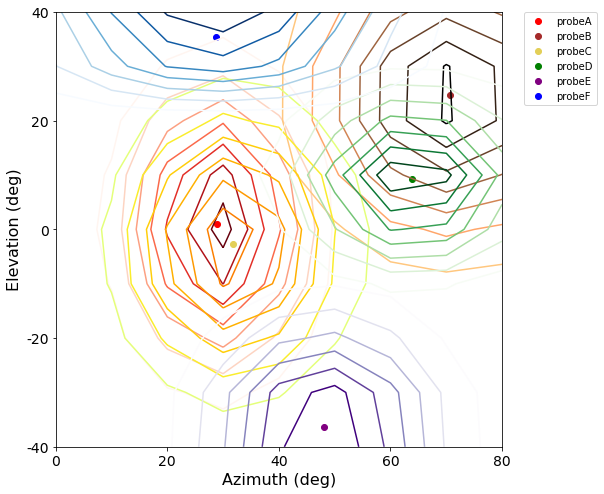

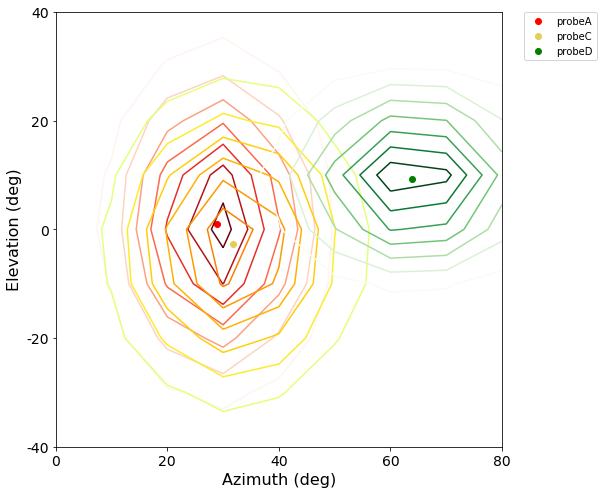

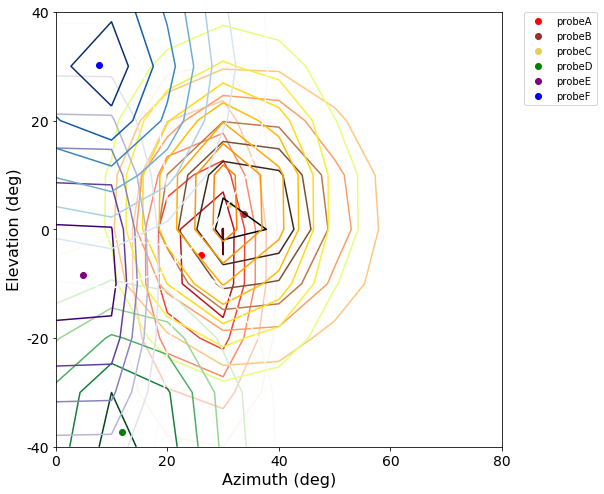

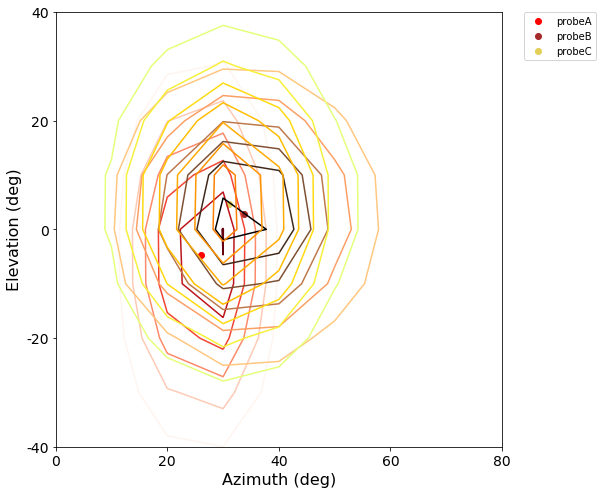

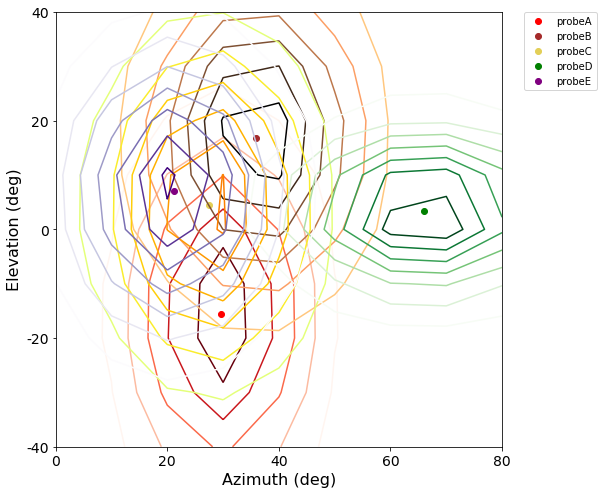

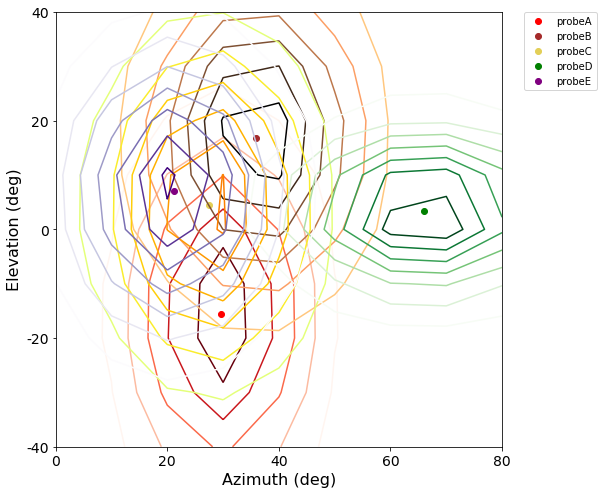

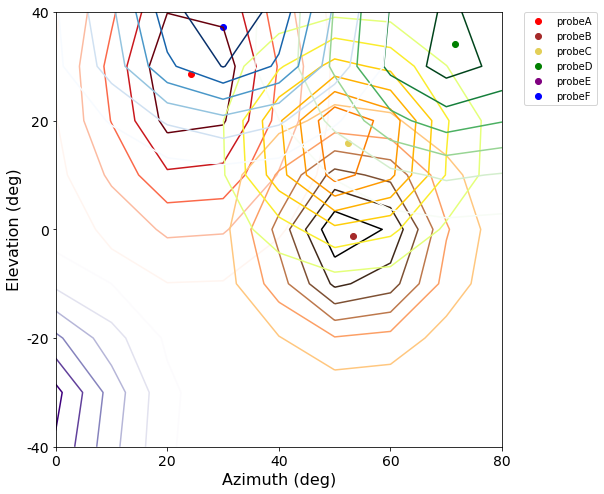

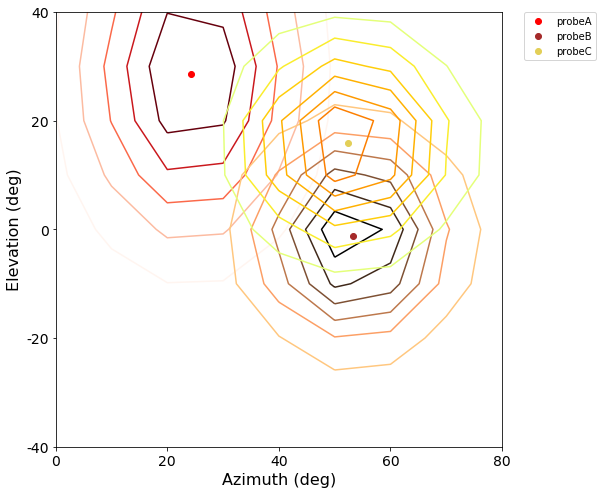

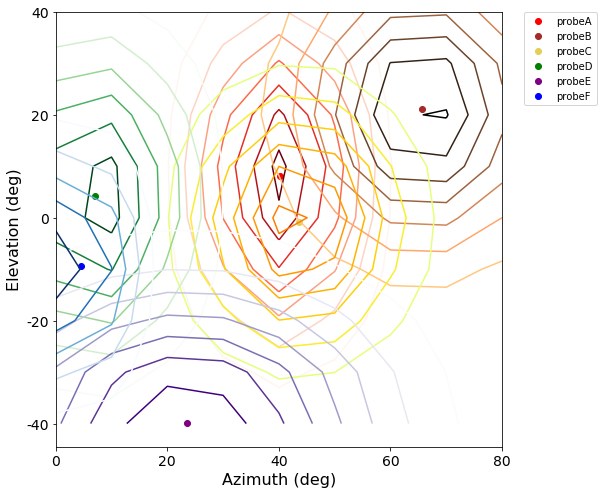

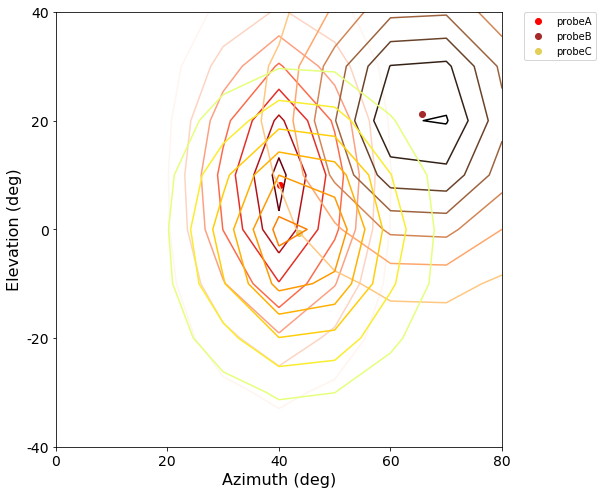

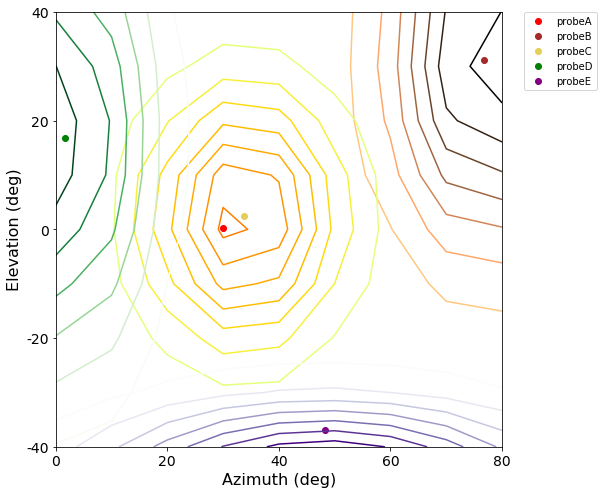

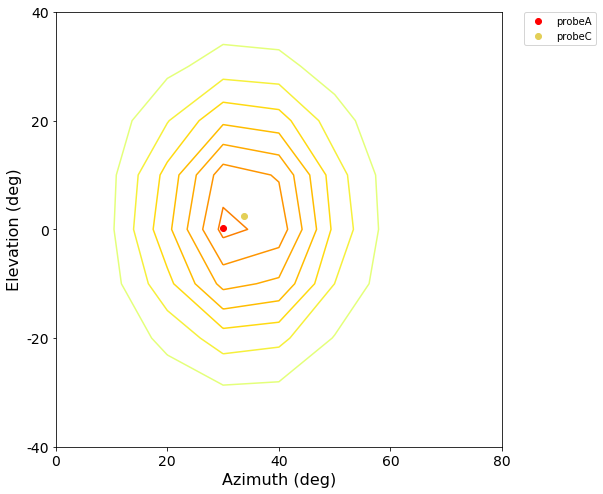

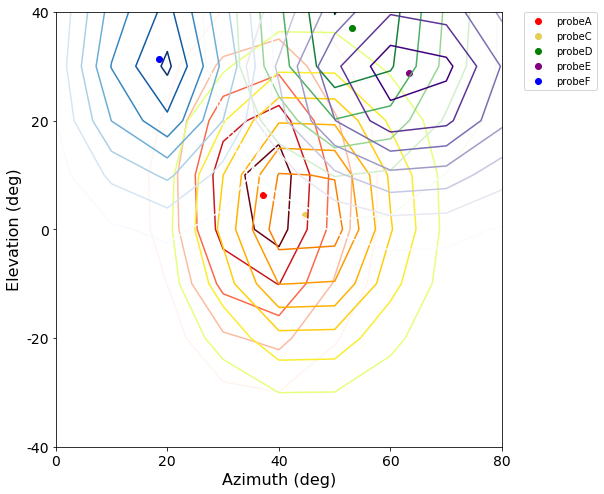

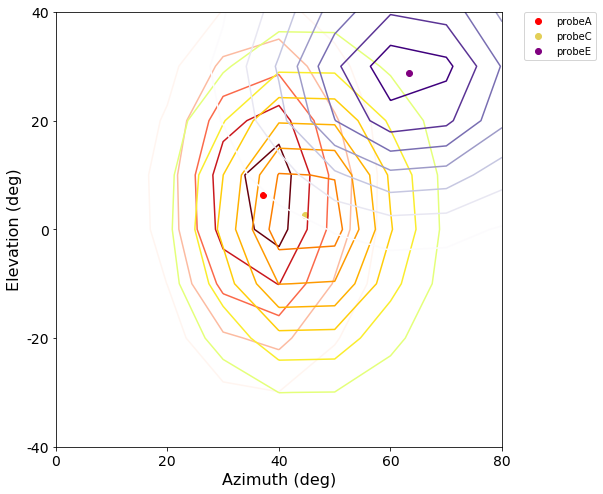

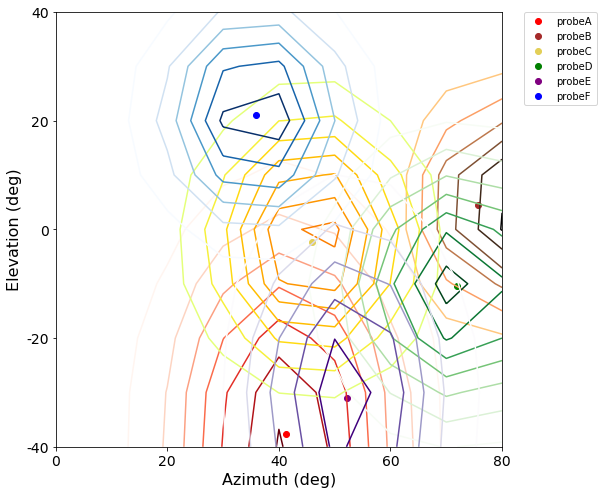

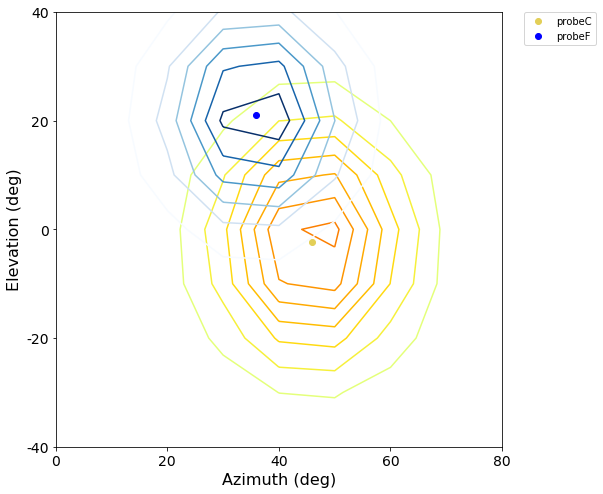

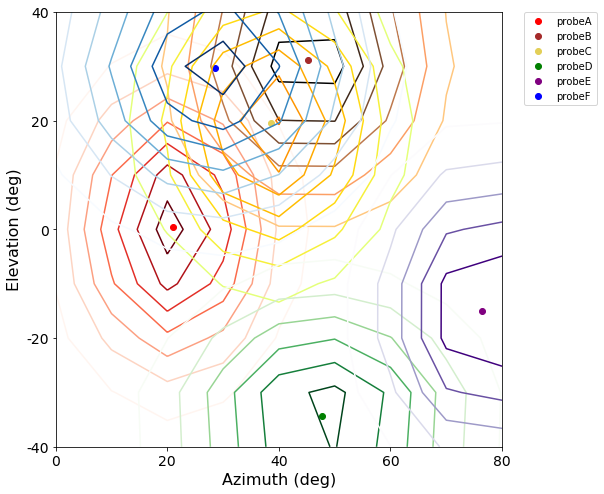

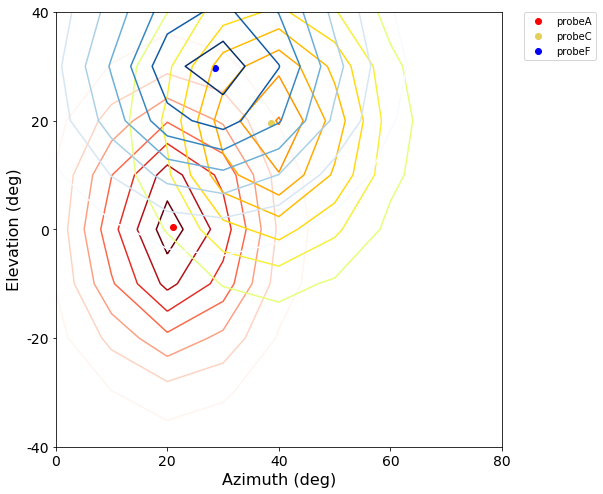

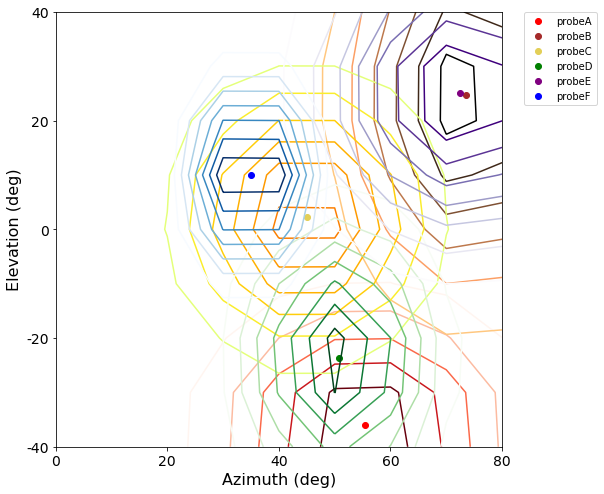

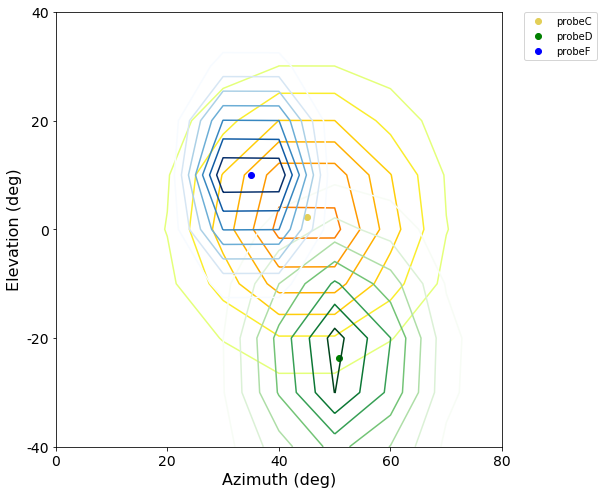

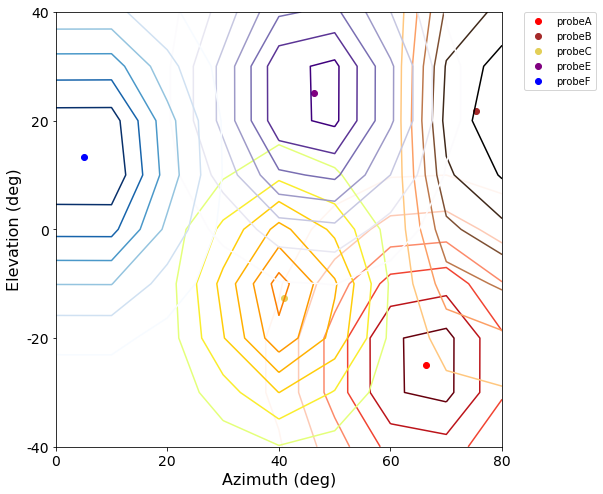

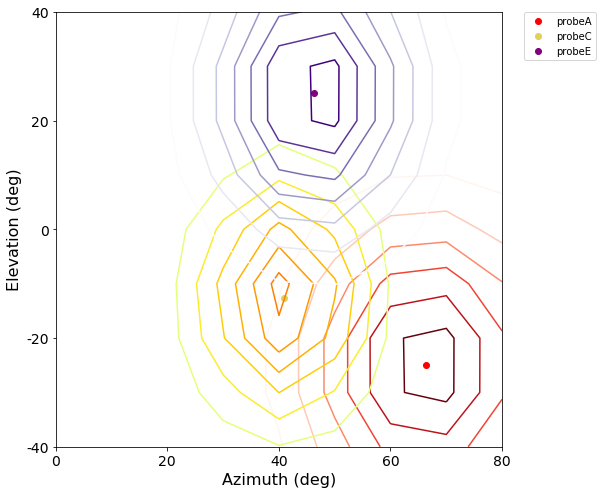

In [16]:
# define nwb filepath and name
filename = 'spikes.nwb' 
nwbpath = 'where your nwb file is'
# read nwb file
nwb_data = h5py.File(os.path.join(nwbpath,filename),'r')

probenames = nwb_data['processing'].keys()
keys = nwb_data['stimulus']['presentation'].keys()

#packaged RF fit for each probe to get aggregated RF
RF_all={}
P={}
for probename in probenames:
    test_obj = nwb_adapter_spikes.NWB_adapter(nwb_data)

    for key in keys:
        if 'gabor' in key:
            break
    #key='gabor_20_deg_250ms_0'

    # estimate wm: three different ways
    #file_name = '/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/channel_wm/'+mouseID+'_surface.csv'
    #df = pd.read_csv(file_name, sep='\t')
    #wm = df[df.probe_id==probename]['wm_depth'].values[0]

    stim_table = test_obj.get_stim_table(key)
    ISI = test_obj.get_ISI(stim_table)
    interval = test_obj.get_interval(stim_table)
    print(ISI, interval)

    set_thresh=False

    df_probe = test_obj.get_unit_meta(probename)
    structures = df_probe.ccf.unique().astype(str)
    cortex = [s for s in structures if 'VIS' in s][0]
    #print(cortex)
    # delay 70ms, 0.07sec
    unit_binarized, unit_list_V1, channel_list_V1, channel_ypos_V1, snr_v1 = test_obj.get_probe_ccf(
        probename, key = key, target_structure=cortex, pre_time=0., post_time=interval+0.05)

    if set_thresh==True:
        unit_binarized = unit_binarized[snr_v1>=1.5,:,:]
        unit_list_V1 = unit_list_V1[snr_v1>=1.5]
        channel_list_V1 = channel_list_V1[snr_v1>=1.5]
        channel_ypos_V1 =channel_ypos_V1[snr_v1>=1.5]
        cell_type_V1 = np.array(cell_type_V1)[snr_v1>=1.5]
        snr_v1=snr_v1[snr_v1>=1.5]
    #print(len(unit_list_V1))

    # get PSTH and check whether neurons are driven by stimulus
    unit_psth, time = nwb_adapter_spikes.get_PSTH(unit_binarized, PSTH_bintime=10)
    #plt.plot(time, unit_psth.mean(0).mean(0))

    # get FR
    FR, FR_ISI = nwb_adapter_spikes.get_FR(unit_binarized, ISI, interval, delay=80)

    # calculate response map
    rf = RFmap.get_RF_map(FR, stim_table)

    # population RF
    data = rf.mean(0)
    #plt.figure(figsize=(8,8))
    #ax = plt.subplot(1,1,1)
    #ax.imshow(rf.mean(0), cmap='Greys')
    ##ax.colorbar()
    #ax.grid(False)

    if sum(data.flatten())>0:
        thresh = 0.2
        thresh_step = 0.1
        peak_mask = ReceptiveFieldAnalysis.get_peak_weighted_roi(data, max(data.ravel())*thresh)
        #if peak_mask==None:
            #print('skip')
            #continue

        #if threshold is not effective, use step-wise increase of threshold
        while len(np.where(peak_mask.flatten()!=0)[0])>20:
            print thresh
            thresh+=thresh_step
            peak_mask = ReceptiveFieldAnalysis.get_peak_weighted_roi(data, max(data.ravel())*thresh)
            if np.nanmax(peak_mask)==None:
                thresh-=thresh_step
                peak_mask = ReceptiveFieldAnalysis.get_peak_weighted_roi(data, max(data.ravel())*thresh)

        params, success = fit_RF_2D.fitgaussian(peak_mask)
        fit = fit_RF_2D.gaussian(*params)
        RF_all[probename] = fit
        P[probename] = params

        RF_fit = fit(*np.indices(data.shape))
        #ax.contour(RF_fit, cmap=plt.cm.copper)
        #axx = plt.gca()
        # fixed bug in x and y position of RF fit
        (height, x, y, width_x, width_y) = params
        print(y, 8-x, min([width_x, width_y])) #8-x

#summary of aggregated RF from all probes  
# areas = ['AM', 'PM', 'V1', 'LM', 'AL', 'RL']
plt.figure(figsize=(8,8))
df=pd.DataFrame(columns=['probe_id', 'x', 'y', 'x_std', 'y_std', 'height'])
for probename in np.sort(RF_all.keys()):
    params = P[probename]
    x = params[2]
    y = 8-params[1]
    plt.scatter(x, y, c=cmaps_color[probename], label=probename)
    print(probename+'  '+str(params[2])+' '+str(8-params[1]))

    plt.contour(np.flipud(RF_all[probename](*np.indices(data.shape))), cmap=cmaps[probename], label=probename)

    df = df.append({'probe_id':probename,
                    'x': params[2],
                    'y':8-params[1],
                    'x_std': params[4],
                    'y_std': params[3],
                    'height':params[0]
                     },
                    ignore_index=True)
df.to_csv('/path/RF_center/'+mouseID+'_aggregatedRF_center.csv')


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([0,8])
labels = [0, 20, 40, 60, 80]
plt.xticks([0, 2, 4, 6, 8], labels, fontsize=14)
plt.xlabel('Azimuth (deg)', fontsize=16)
labels = [-40,-20,0,20,40]
plt.yticks([0, 2, 4, 6, 8], labels, fontsize=14)
plt.ylabel('Elevation (deg)', fontsize=16)
plt.savefig('/path/RF/RF'+mouseID+'all_probes_cortex.pdf')

#summary of RF without edge effect
plt.figure(figsize=(8,8))
for probename in np.sort(RF_all.keys()):
    params = P[probename]
    x = params[2]
    y = 8-params[1]
    # remove RF center close to edge
    if x>1 and x<7 and y>1 and y<7:
        plt.scatter(x, y, c=cmaps_color[probename], label=probename)
        #print(probename+'  '+str(params[2])+' '+str(8-params[1]))

        plt.contour(np.flipud(RF_all[probename](*np.indices(data.shape))), cmap=cmaps[probename], label=probename)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([0,8])
labels = [0, 20, 40, 60, 80]
plt.xticks([0, 2, 4, 6, 8], labels, fontsize=14)
plt.xlabel('Azimuth (deg)', fontsize=16)
labels = [-40,-20,0,20,40]
plt.yticks([0, 2, 4, 6, 8], labels, fontsize=14)
plt.ylabel('Elevation (deg)', fontsize=16)
plt.savefig('/path/RF/RF'+mouseID+'all_probes_cortex_center.pdf')



In [15]:
mouse_IDs

['',
 '',
 'mouse387858',
 'mouse388521',
 'mouse392810',
 'mouse394208',
 'mouse397075',
 'mouse398261',
 'mouse398263',
 'mouse403407',
 'mouse404551',
 'mouse404553',
 'mouse404554',
 'mouse404555',
 'mouse404568',
 'mouse404569',
 'mouse404570',
 'mouse404571',
 'mouse404573',
 'mouse405751',
 'mouse405755',
 'mouse406805',
 'mouse406807',
 'mouse406808',
 'mouse407972',
 'mouse408152',
 'mouse410315',
 'mouse410343',
 'mouse412791',
 'mouse412792',
 'mouse412793',
 'mouse412794',
 'mouse412795',
 'mouse412799',
 'mouse412801',
 'mouse412802',
 'mouse412803',
 'mouse417678',
 'mouse417679',
 'mouse420079']

probeA  3.14734713624 2.09821474762
probeB  7.07660675082 7.01638233154
probeC  3.75601156014 2.56332108353
probeD  0.564153300522 5.35626442825
probeE  5.41706310277 3.95819443181
probeF  1.24422475852 3.85337072854


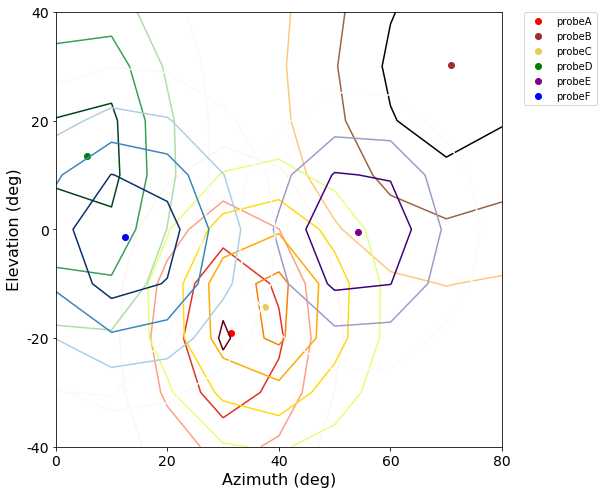

In [17]:
plt.figure(figsize=(8,8))
df=pd.DataFrame(columns=['probe_id', 'x', 'y', 'x_std', 'y_std', 'height'])
for probename in np.sort(RF_all.keys()):
    params = P[probename]
    x = params[2]
    y = 8-params[1]
    plt.scatter(x, y, c=cmaps_color[probename], label=probename)
    print(probename+'  '+str(params[2])+' '+str(8-params[1]))

    plt.contour(np.flipud(RF_all[probename](*np.indices(data.shape))), 4, cmap=cmaps[probename], label=probename)

    df = df.append({'probe_id':probename,
                    'x': params[2],
                    'y':8-params[1],
                    'x_std': params[4],
                    'y_std': params[3],
                    'height':params[0]
                     },
                    ignore_index=True)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([0,8])
labels = [0, 20, 40, 60, 80]
plt.xticks([0, 2, 4, 6, 8], labels, fontsize=14)
plt.xlabel('Azimuth (deg)', fontsize=16)
labels = [-40,-20,0,20,40]
plt.yticks([0, 2, 4, 6, 8], labels, fontsize=14)
plt.ylabel('Elevation (deg)', fontsize=16)
df.to_csv('/path/RF_center/'+mouseID+'_aggregatedRF_center.csv')
